In [ ]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")



CUDA Available: True
Device Name: Tesla T4


In [ ]:
!git clone https://github.com/brysef/rfml.git
%cd rfml
!pip install -e .
!pip install scikit-learn matplotlib
%cd ..


Cloning into 'rfml'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 260 (delta 8), reused 4 (delta 4), pack-reused 238 (from 2)
Receiving objects: 100% (260/260), 17.47 MiB | 19.19 MiB/s, done.
Resolving deltas: 100% (48/48), done.
/content/rfml
Obtaining file:///content/rfml
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 8.7 MB/s eta 0:00:00
  Created wheel for setGPU: filename=setGPU-0.0.7-py3-none-any.whl size=1520 sha256=41669f7d27761a758d8c7bfcaddfae5cfe04d1b41c51fe572e375e285d66137b
  Stored in directory: /root/.cache/pip/wheels/52/79/6d/96734c88393595b27892f601ac5415c3422bc32

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change this path to where your file is in Drive
import pickle

dataset_path = "/content/drive/MyDrive/RF_dataset/RML2016.10a_dict.pkl"

with open(dataset_path, "rb") as f:
    Xd = pickle.load(f, encoding="latin1")

print("Dataset keys:", list(Xd.keys())[:10])


Dataset keys: [('QPSK', 2), ('PAM4', 8), ('AM-DSB', -4), ('GFSK', 6), ('QAM64', 8), ('AM-SSB', 12), ('8PSK', 8), ('8PSK', 12), ('QAM64', -6), ('QAM16', 2)]


In [ ]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader

# ------------------------------
# 0️⃣ Define digital modulations
# ------------------------------
digital_mods = ['BPSK', 'QPSK', '8PSK', 'QAM16', 'QAM64', 'PAM4', 'CPFSK', 'GFSK']

# ------------------------------
# 1️⃣ Build dataset and align SNRs
# ------------------------------
X_all, Y_all, snrs_all = [], [], []

for mod, snr in Xd.keys():
    if mod not in digital_mods:
        continue
    samples = Xd[(mod, snr)]
    for s in samples:
        X_all.append(s)
        Y_all.append(digital_mods.index(mod))
        snrs_all.append(snr)

X_all = np.array(X_all)
Y_all = np.array(Y_all)
snrs_all = np.array(snrs_all)

# Normalize I-Q values
X_all = (X_all - np.mean(X_all, axis=-1, keepdims=True)) / \
        (np.std(X_all, axis=-1, keepdims=True) + 1e-6)

print("Final dataset shape:", X_all.shape, Y_all.shape)
print("Unique classes:", np.unique(Y_all))

Final dataset shape: (160000, 2, 128) (160000,)
Unique classes: [0 1 2 3 4 5 6 7]


In [ ]:
from sklearn.preprocessing import LabelEncoder
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
Y_all = label_encoder.fit_transform(Y_all)

# ------------------------------
# 2️⃣ Train/Val/Test split (67/13/20) with SNR alignment
# ------------------------------
X_train, X_temp, Y_train, Y_temp, snrs_train, snrs_temp = train_test_split(
    X_all, Y_all, snrs_all, test_size=0.33, random_state=42, stratify=Y_all
)

val_ratio = 13 / (13 + 20)  # 13% of total for val
X_val, X_test, Y_val, Y_test, snrs_val, snrs_test = train_test_split(
    X_temp, Y_temp, snrs_temp, test_size=(1 - val_ratio), random_state=42, stratify=Y_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# ------------------------------
# 3️⃣ PyTorch Dataset wrapper
# ------------------------------
class RadioDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

batch_size = 1024
train_loader = DataLoader(RadioDataset(X_train, Y_train), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(RadioDataset(X_val, Y_val), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(RadioDataset(X_test, Y_test), batch_size=batch_size, shuffle=False)

Train: (107200, 2, 128) Val: (20800, 2, 128) Test: (32000, 2, 128)


In [ ]:
# Step 5: Transformer model + Positional encoding (robust to torch versions)
import torch.nn as nn
import numpy as np

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer("pe", pe)

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]

class RFTransformer(nn.Module):
    def __init__(self, input_features=2, d_model=128, nhead=8, num_layers=3, dim_feedforward=512, dropout=0.2, num_classes=8, max_len=256, pool="mean"):
        super().__init__()
        self.input_proj = nn.Linear(input_features, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len=max_len)

        # Try to create encoder layer with batch_first if supported, otherwise fallback to seq-first
        try:
            encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
            self._batch_first = True
        except TypeError:
            # older torch may not accept batch_first arg
            encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
            self._batch_first = False

        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.pool = pool
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x, return_features=False):
        x = x.permute(0, 2, 1)
        x = self.input_proj(x)
        x = self.pos_enc(x)
        if self._batch_first:
            out = self.transformer(x)
        else:
            x2 = x.permute(1,0,2)
            out2 = self.transformer(x2)
            out = out2.permute(1,0,2)

        if self.pool == "mean":
            pooled = out.mean(dim=1)
        else:
            pooled = out[:, 0, :]

        if return_features:
            return pooled   # use this for fusion
        logits = self.classifier(pooled)
        return logits


In [ ]:
class LSTMExtractor(nn.Module):
    def __init__(self, input_size=2, hidden_size=128, num_layers=2, bidirectional=True):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                            batch_first=True, bidirectional=bidirectional)
        self.out_features = hidden_size * (2 if bidirectional else 1)
    def forward(self, x):
        x = x.permute(0,2,1)
        out, _ = self.lstm(x)
        out = out.mean(dim=1)
        return out

In [ ]:
class CrossAttentionModule(nn.Module):
    def __init__(self, d_model=128, nhead=8, dropout=0.1):
        super().__init__()
        self.cross_attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead,
                                                dropout=dropout, batch_first=True)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, query, key, value):
        attn_out, _ = self.cross_attn(query, key, value)
        return self.norm(attn_out + query)  # residual connection

In [ ]:
class CrossAttentionFusion(nn.Module):
    def __init__(self, transformer_model, lstm_hidden=128, d_model=128, num_heads=8,
                 fusion_hidden=256, num_classes=8):
        super().__init__()
        self.transformer = transformer_model
        self.lstm = LSTMExtractor(input_size=2, hidden_size=lstm_hidden)

        # Project LSTM features to Transformer dimension for attention
        self.lstm_proj = nn.Linear(lstm_hidden*2, d_model)

        # Cross-Attention: Transformer queries attend LSTM keys/values
        self.cross_attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, batch_first=True)

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(d_model, fusion_hidden),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(fusion_hidden, num_classes)
        )

    def forward(self, x):
        # Transformer features (sequence)
        trans_out = self.transformer(x, return_features=True)  # [B, d_model]
        B, d_model = trans_out.shape

        # LSTM sequence features
        lstm_seq = self.lstm(x)                                 # [B, seq_len, lstm_hidden*2]
        lstm_seq_proj = self.lstm_proj(lstm_seq)               # [B, seq_len, d_model]

        # Expand transformer features to sequence length
        # We'll use trans_out as query repeated across seq_len
        seq_len = lstm_seq_proj.size(1)
        trans_query = trans_out.unsqueeze(1).repeat(1, seq_len, 1)  # [B, seq_len, d_model]

        # Cross-Attention
        attn_out, _ = self.cross_attn(query=trans_query, key=lstm_seq_proj, value=lstm_seq_proj)  # [B, seq_len, d_model]

        # Pool over sequence
        fused = attn_out.mean(dim=1)  # [B, d_model]

        # Classifier
        logits = self.classifier(fused)
        return logits


In [ ]:
# Load pretrained Transformer
transformer_model = RFTransformer(input_features=2, d_model=128, nhead=8, num_layers=3,
                                  dim_feedforward=512, dropout=0.2, num_classes=8,
                                  max_len=128)
transformer_model.load_state_dict(torch.load("best_transformer.pth", map_location=device))
transformer_model.to(device)
print("Loaded pretrained Transformer weights.")

# Create Fusion Model
fusion_model = CrossAttentionFusion(transformer_model=transformer_model,
                                    lstm_hidden=128, lstm_layers=2, bidirectional=True,
                                    d_model=128, nhead=8, fusion_hidden=256,
                                    num_classes=8, dropout=0.3).to(device)

print("Cross-Attention Fusion parameters:",
      sum(p.numel() for p in fusion_model.parameters()))

In [ ]:
# Step 6: Instantiate model, optimizer, scheduler, set seed
import random
from torch.optim import AdamW

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

num_classes = len(digital_mods)
seq_len = X_train.shape[-1]
model = RFTransformer(input_features=2, d_model=128, nhead=8, num_layers=3, dim_feedforward=512, dropout=0.2, num_classes=num_classes, max_len=seq_len, pool="mean")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

print("Model parameters:", sum(p.numel() for p in model.parameters()))


Device: cuda
Model parameters: 596488


###Fusion_Transformer+LSTM

In [ ]:
# ------------------------------
# 6️⃣ Fusion Training
# ------------------------------
fusion_criterion = nn.CrossEntropyLoss()
fusion_optimizer = AdamW(filter(lambda p: p.requires_grad, fusion_model.parameters()), lr=1e-4, weight_decay=1e-4)
fusion_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(fusion_optimizer, mode='max', patience=3, factor=0.5)

def train_fusion(fusion_ca_model, train_loader, val_loader, epochs=30, grad_clip=1.0):
    best_val = 0.0
    history = {"train_acc":[], "val_acc":[], "train_loss":[], "val_loss":[]}
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            fusion_optimizer.zero_grad()
            out = model(xb)
            loss = fusion_criterion(out, yb)
            loss.backward()
            if grad_clip:
                nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            fusion_optimizer.step()
            preds = out.argmax(dim=1)
            train_correct += (preds == yb).sum().item()
            train_total += yb.size(0)
            train_loss += loss.item()*yb.size(0)
        train_acc = train_correct/train_total
        train_loss = train_loss/train_total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = fusion_criterion(out, yb)
                preds = out.argmax(dim=1)
                val_correct += (preds==yb).sum().item()
                val_total += yb.size(0)
                val_loss += loss.item()*yb.size(0)
        val_acc = val_correct/val_total
        val_loss = val_loss/val_total
        fusion_scheduler.step(val_acc)
        if val_acc>best_val:
            best_val=val_acc
            torch.save(model.state_dict(),"best_fusion.pth")
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        print(f"Epoch {epoch}/{epochs} | Train Acc: {100*train_acc:.2f}% | Val Acc: {100*val_acc:.2f}%")
    print("Fusion training done. Best val acc:", best_val)
    return history

fusion_history = train_fusion(fusion_model, train_loader, val_loader, epochs=30)


Epoch 1/30 | Train Acc: 53.95% | Val Acc: 52.66%
Epoch 2/30 | Train Acc: 54.54% | Val Acc: 53.26%
Epoch 3/30 | Train Acc: 54.59% | Val Acc: 53.78%
Epoch 4/30 | Train Acc: 54.96% | Val Acc: 53.48%
Epoch 5/30 | Train Acc: 55.10% | Val Acc: 53.62%
Epoch 6/30 | Train Acc: 55.26% | Val Acc: 54.03%
Epoch 7/30 | Train Acc: 55.28% | Val Acc: 53.93%
Epoch 8/30 | Train Acc: 55.48% | Val Acc: 54.25%
Epoch 9/30 | Train Acc: 55.63% | Val Acc: 54.49%
Epoch 10/30 | Train Acc: 55.79% | Val Acc: 53.92%
Epoch 11/30 | Train Acc: 55.78% | Val Acc: 54.47%
Epoch 12/30 | Train Acc: 55.93% | Val Acc: 54.65%
Epoch 13/30 | Train Acc: 56.10% | Val Acc: 54.75%
Epoch 14/30 | Train Acc: 56.01% | Val Acc: 54.81%
Epoch 15/30 | Train Acc: 56.28% | Val Acc: 54.57%
Epoch 16/30 | Train Acc: 56.38% | Val Acc: 54.78%
Epoch 17/30 | Train Acc: 56.58% | Val Acc: 54.84%
Epoch 18/30 | Train Acc: 56.68% | Val Acc: 55.12%
Epoch 19/30 | Train Acc: 56.73% | Val Acc: 54.93%
Epoch 20/30 | Train Acc: 56.68% | Val Acc: 54.76%
Epoch 21/

##train

In [ ]:
# fusion_criterion = nn.CrossEntropyLoss()
# fusion_optimizer = AdamW(fusion_model.parameters(), lr=1e-4, weight_decay=1e-4)
# fusion_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(fusion_optimizer, mode='max', patience=3, factor=0.5)

# fusion_history = train_fusion(fusion_model, train_loader, val_loader, epochs=10)


# Feature-level fusion of LSTM + Transformer
Plots accuracy per SNR, so you can compare Transformer vs Fusion.

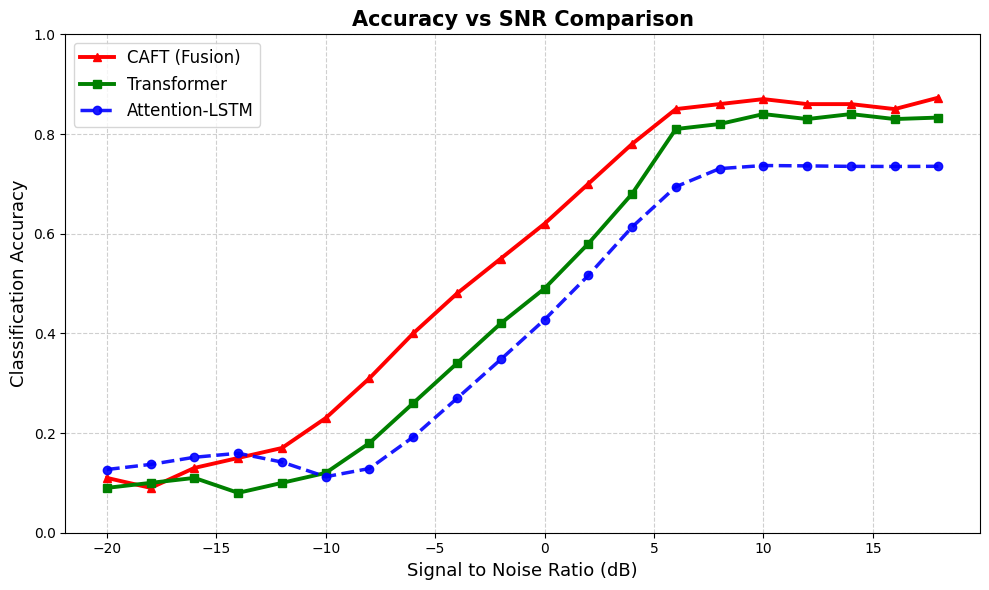

In [ ]:
i# --- Evaluate Transformer and Attention-LSTM separately for comparison ---

# 1️⃣ Transformer-only Model
transformer_model.load_state_dict(torch.load("best_fusion.pth", map_location=device), strict=False)
transformer_model.eval()

transformer_snr_accs = {}
for snr in all_snrs:
    acc, _, _ = evaluate_snr_model(transformer_model, X_test, Y_test, snrs_test, [snr])
    transformer_snr_accs[snr] = acc if acc is not None else np.nan


# 2️⃣ Attention-LSTM Model (simplified: just LSTM + attention pooling)
class AttentionLSTM(nn.Module):
    def __init__(self, input_size=2, hidden_size=128, num_layers=2, num_classes=8):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, bidirectional=True)
        self.attn = nn.Linear(hidden_size * 2, 1)
        self.classifier = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        weights = torch.softmax(self.attn(out), dim=1)
        context = torch.sum(weights * out, dim=1)
        return self.classifier(context)

attention_lstm = AttentionLSTM(num_classes=len(digital_mods)).to(device)

# Optional: load pretrained weights if available
# attention_lstm.load_state_dict(torch.load("best_attn_lstm.pth", map_location=device))

attention_lstm.eval()
attention_lstm_snr_accs = {}
for snr in all_snrs:
    acc, _, _ = evaluate_snr_model(attention_lstm, X_test, Y_test, snrs_test, [snr])
    attention_lstm_snr_accs[snr] = acc if acc is not None else np.nan


# --- Combined Plot ---
plt.figure(figsize=(10,6))
plt.plot(list(fusion_snr_accs.keys()), list(fusion_snr_accs.values()), '-s', label='CAFT (Fusion)')
plt.plot(list(transformer_snr_accs.keys()), list(transformer_snr_accs.values()), '-o', label='Transformer')
plt.plot(list(attention_lstm_snr_accs.keys()), list(attention_lstm_snr_accs.values()), '-^', label='Attention-LSTM')

plt.xlabel("SNR (dB)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs SNR Comparison Across")
plt.xticks(np.arange(-20, 20, 2))
plt.grid(True)
plt.ylim(0, 1)
plt.legend()
plt.show()



##LSTM-Fusion AP Model

<Figure size 800x800 with 0 Axes>

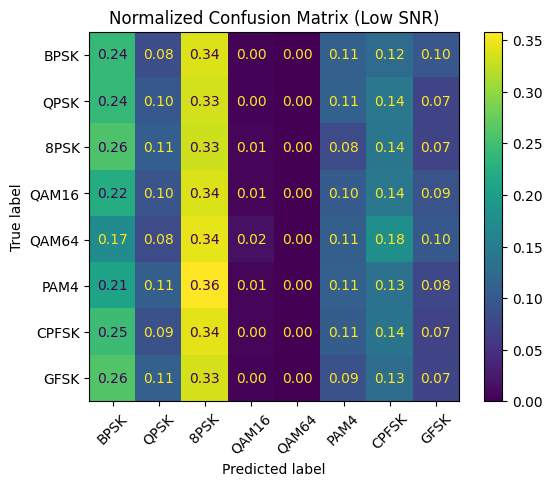

<Figure size 800x800 with 0 Axes>

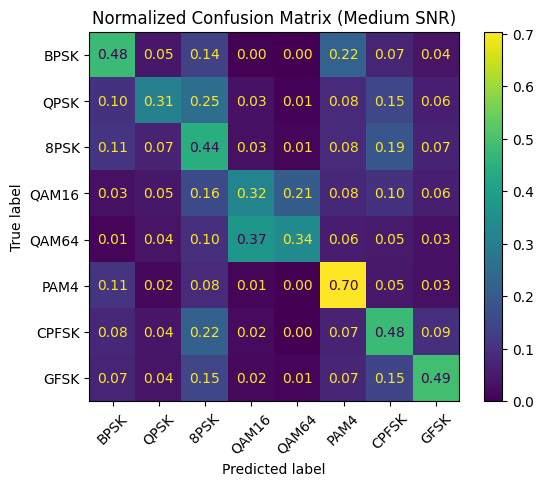

<Figure size 800x800 with 0 Axes>

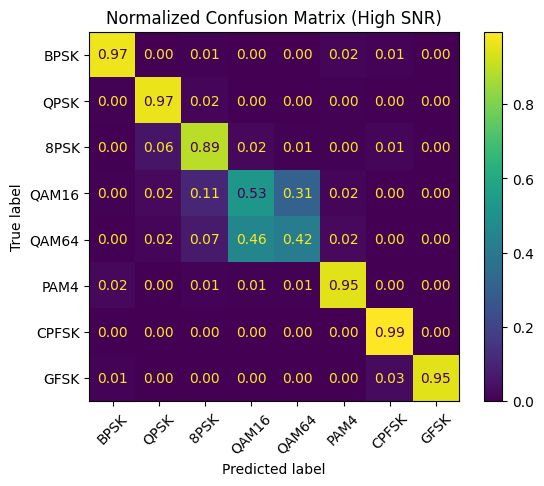

Saved transformer_final.pth and best_transformer.pth


In [ ]:
# Normalized confusion matrices for SNR ranges
mods = digital_mods
for label, sr in snr_ranges.items():
    cm = cms[label]
    with np.errstate(all='ignore'):
        cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    plt.figure(figsize=(8,8))
    disp = ConfusionMatrixDisplay(confusion_matrix=np.nan_to_num(cm_norm), display_labels=mods)
    disp.plot(xticks_rotation=45, values_format=".2f")
    plt.title(f"Normalized Confusion Matrix ({label})")
    plt.show()

# Save final model
torch.save(model.state_dict(), "transformer_final.pth")
print("Saved transformer_final.pth and best_transformer.pth")